In [1]:
# import table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as ra
import json
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F

from dp_processor import Processor
from dp_wgan import Generator, Discriminator
from dp_autoencoder import Autoencoder
import dp_optimizer, sampling, analysis

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter

from dpv.data_utility import emd_utility, log_diff


# settings
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# import xes event log (BPIC2012 example)
log = importer.apply('BPIC13.xes')

parsing log, completed traces :: 100%|██████████| 7554/7554 [00:01<00:00, 4524.00it/s]


In [3]:
# extract variants
variants = variants_filter.get_variants(log)

# number of variants
len(variants)

1511

In [586]:
# create dataframe
var_log = []

for var in variants:
    var_log += [var] * len(variants[var])
    
ra.shuffle(var_log)
df = pd.DataFrame({'variant': var_log})
df_orig = pd.DataFrame({'orig': var_log})
df

,variant
0,"Accepted,Accepted,Completed"
1,"Accepted,Accepted,Completed"
2,"Accepted,Accepted,Queued,Accepted,Accepted,Acc..."
3,"Accepted,Accepted,Queued,Accepted,Accepted,Com..."
4,"Accepted,Accepted,Completed,Completed"
...,...
7549,"Accepted,Accepted,Queued,Accepted,Accepted,Acc..."
7550,"Accepted,Accepted,Accepted,Queued,Accepted,Que..."
7551,"Accepted,Accepted,Queued,Accepted,Accepted,Com..."
7552,"Accepted,Accepted,Queued,Accepted,Accepted,Que..."


In [587]:
# init data processor
datatypes = [('variant', 'categorical')]
processor = Processor(datatypes)

# encode categories
for column, datatype in datatypes:
    if 'categorical' in datatype:
        df[column] = df[column].astype('category').cat.codes

# init training data
train_df = df.head(int(len(df)*0.99))
train_cutoff = int(len(df)*0.99)

# create tensor data
X_real = torch.tensor(df.values, dtype=torch.float32)
X_encoded = torch.tensor(processor.fit_transform(X_real), dtype=torch.float32)

# create train / test tensors
X_train_real = X_real[:train_cutoff]
X_test_real = X_real[train_cutoff:]

# create encoded train / test tensors
X_train_encoded = X_encoded[:train_cutoff]
X_test_encoded = X_encoded[train_cutoff:]

# print preview
print(X_train_encoded, X_train_encoded.shape)
print(X_test_encoded, X_test_encoded.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([7478, 1511])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([76, 1511])


In [588]:
# autoencoder config
ae_params = {
    'b1': 0.9,
    'b2': 0.999,
    'binary': True,
    'compress_dim': 128,
    'delta': 1e-6,
    'device': 'cpu',
    'iterations': 20000,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.012,
    'minibatch_size': 64,
    'microbatch_size': 1,
    'noise_multiplier': 6,
    'nonprivate': True,
}

# OPTIMIZED HYPERPARAMETER

# 0.01
# 2 : 1.9, 64, 20000
# 1 : 4, 64, 20000
# 0.1 : 10, 32, 20000
# 0.01: 100, 64, 20000

# 0.001
# 2: 2.5 64 20k
# 1: 4.7 64 20k 
# 0.1: 11 32 20k 
# 0.01: 140 64 20k

# 0.0001
# 2: 2.8, 64, 20k
# 1: 5.5, 64, 20k
# 0.1: 20, 64, 20k
# 0.01: 180, 64, 20k

# -5
# 2: 3 64 20k
# 1: 5.3 64 20k
# 0.1: 25 64 20k
# 0.01: 220 64 20k

# -6
# 2: 3.5 64 20k
# 1: 6 64 20k
# 0.1: 30 64 20k
# 0.01: 270 64 20k

# init autoencoder
autoencoder = Autoencoder(
    example_dim=len(X_train_encoded[0]),
    compression_dim=ae_params['compress_dim'],
    binary=ae_params['binary'],
    device=ae_params['device'],
)

# init decoding optimizer
decoder_optimizer = dp_optimizer.DPAdam(
    l2_norm_clip=ae_params['l2_norm_clip'],
    noise_multiplier=ae_params['noise_multiplier'],
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    nonprivate=ae_params['nonprivate'],
    params=autoencoder.get_decoder().parameters(),
    lr=ae_params['lr'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

# init encoding optimizer
encoder_optimizer = torch.optim.Adam(
    params=autoencoder.get_encoder().parameters(),
    lr=ae_params['lr'] * ae_params['microbatch_size'] / ae_params['minibatch_size'],
    betas=(ae_params['b1'], ae_params['b2']),
    weight_decay=ae_params['l2_penalty'],
)

In [589]:
"""
weights, ds = [], []
for name, datatype in datatypes:
    if 'categorical' in datatype:
        num_values = len(np.unique(df[name]))
        if num_values == 2:
            weights.append(1.)
            ds.append((datatype, 1))
        else:
            for i in range(num_values):
                weights.append(1. / num_values)
            ds.append((datatype, num_values))
    else:
        weights.append(1.)
        ds.append((datatype, 1))
weights = torch.tensor(weights).to(ae_params['device'])
"""

# define loss
#autoencoder_loss = (lambda input, target: torch.mul(weights, torch.pow(input-target, 2)).sum(dim=1).mean(dim=0))
#autoencoder_loss = lambda input, target: torch.mul(weights, F.binary_cross_entropy(input, target, reduction='none')).sum(dim=1).mean(dim=0)
autoencoder_loss = nn.BCELoss()
#autoencoder_loss = nn.MSELoss()

# print network structure
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1511, out_features=819, bias=True)
    (1): Tanh()
    (2): Linear(in_features=819, out_features=128, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=819, bias=True)
    (1): Tanh()
    (2): Linear(in_features=819, out_features=1511, bias=True)
    (3): Sigmoid()
  )
)


In [590]:
# DP parameter analysis
print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        ae_params['minibatch_size'],
        ae_params['noise_multiplier'],
        ae_params['iterations'],
        ae_params['delta']
    ),
    ae_params['delta'],
))

Achieves (1.0917388663826904, 1e-06)-DP


In [591]:
# init data loader
minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=ae_params['minibatch_size'],
    microbatch_size=ae_params['microbatch_size'],
    iterations=ae_params['iterations'],
    nonprivate=ae_params['nonprivate'],
)

[Iteration 0/20000] [Loss: 0.693621] [Validation Loss: 0.693625]
[Iteration 1000/20000] [Loss: 0.004564] [Validation Loss: 0.004265]
[Iteration 2000/20000] [Loss: 0.003865] [Validation Loss: 0.003380]
[Iteration 3000/20000] [Loss: 0.002888] [Validation Loss: 0.002445]
[Iteration 4000/20000] [Loss: 0.002254] [Validation Loss: 0.001770]
[Iteration 5000/20000] [Loss: 0.001683] [Validation Loss: 0.001429]
[Iteration 6000/20000] [Loss: 0.000983] [Validation Loss: 0.001166]
[Iteration 7000/20000] [Loss: 0.000617] [Validation Loss: 0.000933]
[Iteration 8000/20000] [Loss: 0.000735] [Validation Loss: 0.000912]
[Iteration 9000/20000] [Loss: 0.000633] [Validation Loss: 0.000933]
[Iteration 10000/20000] [Loss: 0.000421] [Validation Loss: 0.000911]
[Iteration 11000/20000] [Loss: 0.000581] [Validation Loss: 0.001046]
[Iteration 12000/20000] [Loss: 0.000419] [Validation Loss: 0.001215]
[Iteration 13000/20000] [Loss: 0.000546] [Validation Loss: 0.001243]
[Iteration 14000/20000] [Loss: 0.000640] [Valid

<AxesSubplot:>

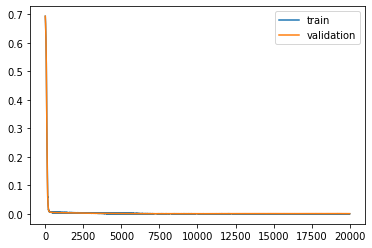

In [592]:
# train autoencoder
train_losses, validation_losses = [], []

X_train_encoded = X_train_encoded.to(ae_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    for X_microbatch in microbatch_loader(X_minibatch):

        decoder_optimizer.zero_microbatch_grad()
        output = autoencoder(X_microbatch)
        loss = autoencoder_loss(output, X_microbatch)
        loss.backward()
        decoder_optimizer.microbatch_step()
        
    validation_loss = autoencoder_loss(autoencoder(X_test_encoded).detach(), X_test_encoded)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    train_losses.append(loss.item())
    validation_losses.append(validation_loss.item())

    if iteration % 1000 == 0:
        print ('[Iteration %d/%d] [Loss: %f] [Validation Loss: %f]' % (
            iteration, ae_params['iterations'], loss.item(), validation_loss.item())
        )

pd.DataFrame(data={'train': train_losses, 'validation': validation_losses}).plot()

In [545]:
# save autoencoder
with open('models/model_13_ae_0.01_0.000001.dat', 'wb') as f:
    torch.save(autoencoder, f)

In [564]:
# load autoencoder
with open('models/model_13_ae_0.01_0.01.dat', 'rb') as f:
    autoencoder = torch.load(f)


In [593]:
# extract decoder
decoder = autoencoder.get_decoder()

In [594]:
# GAN config
gan_params = {
    'alpha': 0.99,
    'binary': True,
    'clip_value': 0.01,
    'd_updates': 15,
    'delta': 1e-6,
    'device': 'cpu',
    'iterations': 1500,
    'latent_dim': 128,
    'lr': 0.005,
    'l2_penalty': 0.,
    'l2_norm_clip': 0.022,
    'minibatch_size': 128,
    'microbatch_size': 1,
    'noise_multiplier': 4,
    'nonprivate': False,
}

# OPTIMIZED HYPERPARAMETER

# 0.01 noise minibatch iter
# 2: 1.3, 128, 1500
# 1: 2.4, 128, 2000
# 0.1: 10, 128, 1500
# 0.01: 60, 128, 1000

# 0.001
# 2: 1.3 128 1500
# 1: 2.5 128 1500
# 0.1: 12 128 1500
# 0.01: 70 128 1000

# 0.0001
# 2: 1.6, 128, 1500
# 1: 3, 128, 1500
# 0.1: 15, 128, 1500
# 0.01: 80, 128, 1000

# -5 
# 2: 1.8 128 1500 
# 1: 3.5 128 1500
# 0.1: 20 128 1500
# 0.01: 100 128 1000

# -6
# 2: 2 128 1500
# 1: 4 128 1500
# 0.1: 25 128 1500
# 0.01: 160 128 1000

generator = Generator(
    input_dim=gan_params['latent_dim'],
    output_dim=autoencoder.get_compression_dim(),
    binary=gan_params['binary'],
    device=gan_params['device'],
)

g_optimizer = torch.optim.RMSprop(
    params=generator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

discriminator = Discriminator(
    input_dim=len(X_train_encoded[0]),
    device=gan_params['device'],
)

d_optimizer = dp_optimizer.DPRMSprop(
    l2_norm_clip=gan_params['l2_norm_clip'],
    noise_multiplier=gan_params['noise_multiplier'],
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    nonprivate=gan_params['nonprivate'],
    params=discriminator.parameters(),
    lr=gan_params['lr'],
    alpha=gan_params['alpha'],
    weight_decay=gan_params['l2_penalty'],
)

print(generator)
print(discriminator)

Generator(
  (block_0): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (block_1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (block_2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1511, out_features=1007, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1007, out_features=503, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=503, out_features=1, bias=True)
  )
)


In [595]:
# privacy analysis
print('Achieves ({}, {})-DP'.format(
    analysis.epsilon(
        len(X_train_encoded),
        gan_params['minibatch_size'],
        gan_params['noise_multiplier'],
        gan_params['iterations'],
        gan_params['delta']
    ),
    gan_params['delta'],
))

Achieves (0.9145814122504278, 1e-06)-DP


In [596]:
# create data loader
minibatch_loader, microbatch_loader = sampling.get_data_loaders(
    minibatch_size=gan_params['minibatch_size'],
    microbatch_size=gan_params['microbatch_size'],
    iterations=gan_params['iterations'],
    nonprivate=gan_params['nonprivate'],
)

[Iteration 0/1500] [D loss: -0.023906] [G loss: 0.008800]


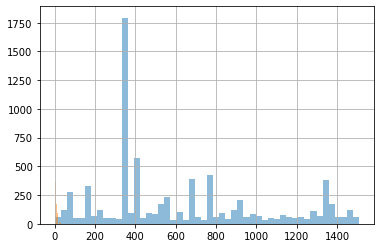

[Iteration 100/1500] [D loss: -0.037729] [G loss: 0.134748]


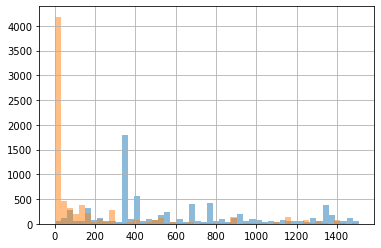

[Iteration 200/1500] [D loss: -0.039008] [G loss: 0.066854]


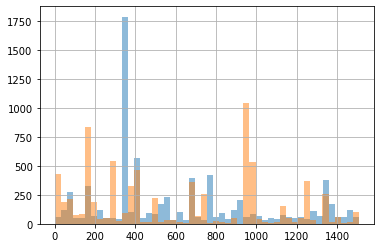

[Iteration 300/1500] [D loss: -0.014390] [G loss: 0.020918]


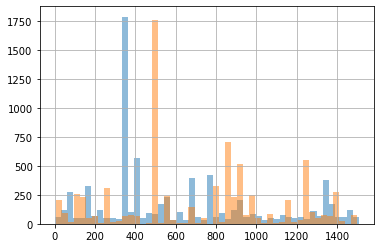

[Iteration 400/1500] [D loss: -0.001687] [G loss: -0.008293]


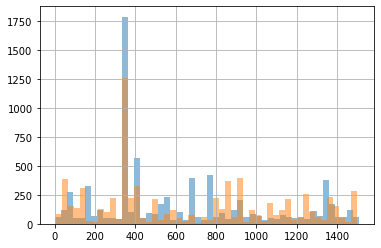

[Iteration 500/1500] [D loss: -0.000427] [G loss: -0.000442]


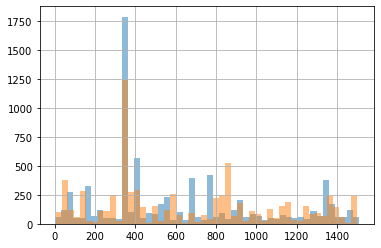

[Iteration 600/1500] [D loss: -0.000288] [G loss: 0.009933]


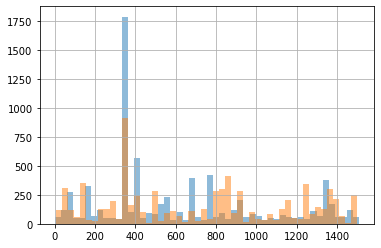

[Iteration 700/1500] [D loss: -0.000325] [G loss: -0.005201]


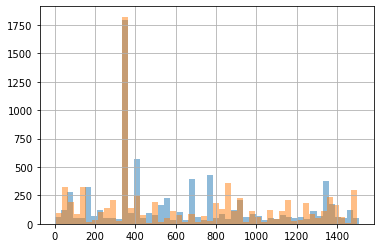

[Iteration 800/1500] [D loss: -0.000454] [G loss: 0.010567]


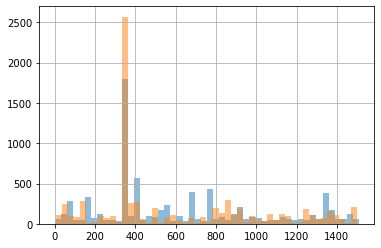

[Iteration 900/1500] [D loss: -0.000324] [G loss: -0.005628]


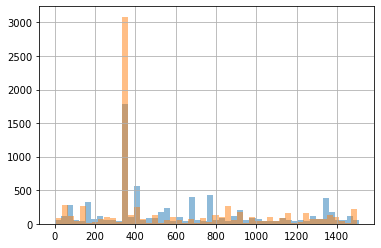

[Iteration 1000/1500] [D loss: -0.000499] [G loss: -0.005668]


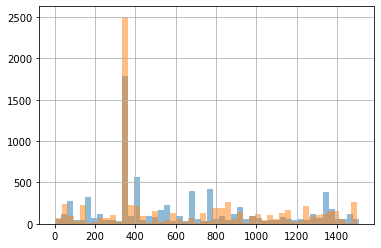

[Iteration 1100/1500] [D loss: 0.000020] [G loss: 0.004669]


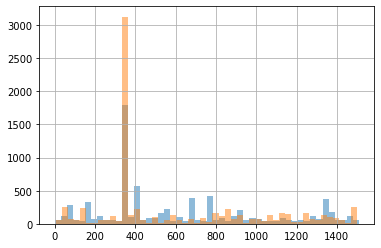

[Iteration 1200/1500] [D loss: -0.000454] [G loss: -0.004290]


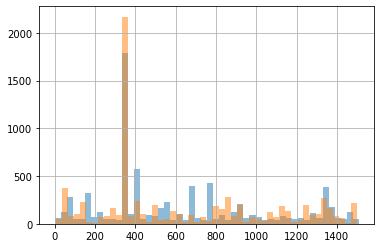

[Iteration 1300/1500] [D loss: -0.000069] [G loss: 0.003566]


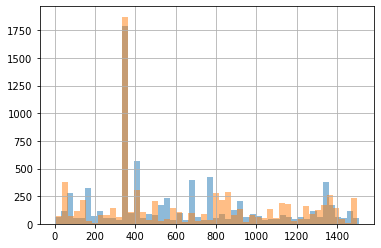

[Iteration 1400/1500] [D loss: -0.000473] [G loss: -0.002302]


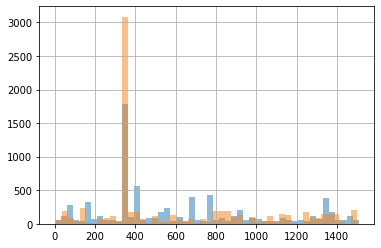

In [597]:
# train GAN
X_train_encoded = X_train_encoded.to(gan_params['device'])
X_test_encoded = X_test_encoded.to(ae_params['device'])

for iteration, X_minibatch in enumerate(minibatch_loader(X_train_encoded)):
    
    d_optimizer.zero_grad()
    
    for real in microbatch_loader(X_minibatch):
        z = torch.randn(real.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z)).detach()
        
        d_optimizer.zero_microbatch_grad()
        d_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        d_loss.backward()
        d_optimizer.microbatch_step()
    
    d_optimizer.step()

    for parameter in discriminator.parameters():
        parameter.data.clamp_(-gan_params['clip_value'], gan_params['clip_value'])

    if iteration % gan_params['d_updates'] == 0:
        z = torch.randn(X_minibatch.size(0), gan_params['latent_dim'], device=gan_params['device'])
        fake = decoder(generator(z))

        g_optimizer.zero_grad()
        g_loss = -torch.mean(discriminator(fake))
        g_loss.backward()
        g_optimizer.step()

    if iteration % 100 == 0:
        print('[Iteration %d/%d] [D loss: %f] [G loss: %f]' % (
            iteration, gan_params['iterations'], d_loss.item(), g_loss.item()
        ))
        
        z = torch.randn(len(X_train_real), gan_params['latent_dim'], device=gan_params['device'])
        X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
        X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
        X_synthetic_encoded = processor.transform(X_synthetic_real)
        synthetic_data = pd.DataFrame(X_synthetic_real, columns=df.columns)

        i = 0
        columns = df.columns
        df[columns[i]].hist(bins=50, alpha=0.5)
        synthetic_data[columns[i]].hist(bins=50, alpha=0.5)
        plt.show()

In [572]:
# save GAN
with open('models/model_13_gan_0.01_0.01.dat', 'wb') as f:
    torch.save(generator, f)

In [573]:
# create mapping
mapping = dict(enumerate(df_orig['orig'].astype('category').cat.categories))

In [31]:
# save and load GAN
with open('models/model_13_gan_0.1_0.01.dat', 'rb') as f:
    generator = torch.load(f)
    
with open('models/model_13_ae_0.1_0.01.dat', 'rb') as f:
    autoencoder = torch.load(f)

In [574]:
# create synthetic data log
decoder = autoencoder.get_decoder()

#z = torch.randn(13087*100, gan_params['latent_dim'], device=gan_params['device'])
z = torch.randn(7554*100,128, device='cpu')
X_synthetic_encoded = decoder(generator(z)).cpu().detach().numpy()
X_synthetic_real = processor.inverse_transform(X_synthetic_encoded)
synthetic_data = pd.DataFrame(X_synthetic_real, columns=df.columns)

In [9]:
# example debugging output
df['variant'].value_counts()

356     1754
418      524
757      352
666      334
1336     300
        ... 
1163       1
94         1
62         1
1214       1
1279       1
Name: variant, Length: 1511, dtype: int64

In [10]:
# example debugging output
synthetic_data['variant'].value_counts()


356.0     88155
451.0     41967
1185.0    19926
812.0     19460
249.0     18641
          ...  
247.0         1
365.0         1
1451.0        1
44.0          1
941.0         1
Name: variant, Length: 447, dtype: int64

In [575]:
# reverse variant names
def reverse(df, mapping):
    
    var_list = dict()
    
    for var in df:
        
        name = mapping[int(var)]
        
        if name in var_list:
            var_list[name] += 1
        else:
            var_list[name] = 1
    
    return var_list

var_orig = reverse(df['variant'], mapping)
var_priv = reverse(synthetic_data['variant'], mapping)

In [576]:
# align variant numbers for plotting
for var in var_orig:
    
    if var not in var_priv.keys():
        var_priv[var] = 0
        
len(var_priv)

1511

In [292]:
# debugging plots
pri = {k:v/100 for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

<BarContainer object of 1511 artists>

Error in callback <function flush_figures at 0x000001AE8375FD00> (for post_execute):


KeyboardInterrupt: 

<BarContainer object of 17 artists>

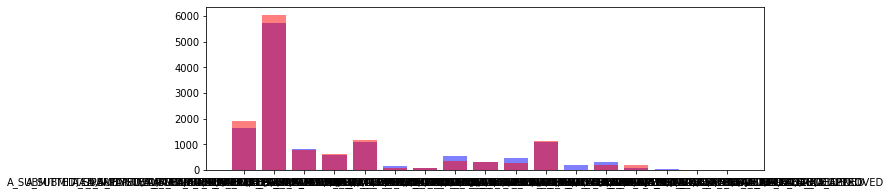

In [24]:
# debugging plots
pri = {k:v/100 for (k, v) in var_priv.items()}
plt.figure(figsize=(10,3))
plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

In [577]:
# debugging plots
pri = {k:int(v/100) for (k, v) in var_priv.items()}
#plt.figure(figsize=(10,3))
#plt.bar(*zip(*var_orig.items()), color='b', alpha=0.5)
#plt.bar(*zip(*pri.items()), color='r', alpha=0.5)

In [578]:
# debugging abs log diff
log_diff(var_orig, pri)

66068

In [579]:
# debugging rel log sim
emd_utility(var_orig, pri)

0.6914720643419622

In [580]:
# save private logs
fp = open(f"logs/variants_gan_0.01_0.01.json", "w")
json.dump(pri, fp)
fp.close()

In [ ]:
# DATA UTILITY RESULTS

        # 0.01      # 0.001     # 0.0001    # 0.00001   # 0.000001
# 2     0.8           0.85          0.85      0.82         0.83
# 1     0.81           0.83         0.82      0.85          0.82
# 0.1   0.71           0.65          0.69       0.64          0.7
# 0.01  0.69           0.65         0.65       0.53          0.55
# 0.001

In [77]:
# RESULT UTILITY RESULTS

        # 0.01      # 0.001     # 0.0001    # 0.00001   # 0.000001
# 2     69k          53k            53k        61k           58k
# 1     55k          61k           58k       54k           52k
# 0.1   80k          88k          89k        108k          88k     
# 0.01  66k          61k          72k       80k           77k
# 0.001